     -------------------------------------- 77.1/77.1 kB 857.1 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\lisag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
100%|██████████| 1000/1000 [01:00<00:00, 16.61it/s]


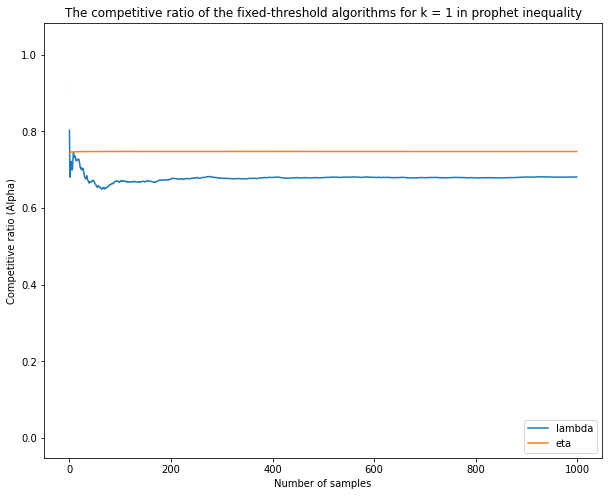

In [3]:
!pip install tqdm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.stats import norm, truncnorm
import heapq


def get_dists(n, mean_interval=10, std_interval=1):
    dists = []
    for _ in range(n):
        mean = np.random.rand() * mean_interval
        std = np.random.rand() * std_interval
        complete_dist = norm(mean, std)
        interval = sorted([complete_dist.rvs(), complete_dist.rvs()])
        truncated_dist = truncnorm(interval[0], interval[1], loc=mean, scale=std)
        dists.append(truncated_dist)
    return dists


def get_x_i(dists):
    x_i = []
    for d in dists:
        x_i.append(d.rvs())
    return x_i


def prophet(x_i, k):
    if k > 1:
        heapq.heapify(x_i)
        results = heapq.nlargest(k, x_i)
        # print("prophet:", results)
        return np.sum(results)
    else:
        return np.max(x_i)


def plot_performance(seed_eta, seed_lambda):
    seed_lambda = np.array(seed_lambda)
    seed_eta = np.array(seed_eta)

    avg_alpha_lambda = np.mean(seed_lambda, axis=0)
    avg_alpha_eta = np.mean(seed_eta, axis=0)

    std_alpha_lambda = np.std(seed_lambda, axis=0) / np.sqrt(seed_lambda.shape[0])
    std_alpha_eta = np.std(seed_eta, axis=0) / np.sqrt(seed_eta.shape[0])

    plt.figure(figsize=[10, 8])
    plt.plot(avg_alpha_lambda, label='lambda')
    plt.fill_between(avg_alpha_lambda - 2.26 * std_alpha_lambda, avg_alpha_lambda + 2.26 * std_alpha_lambda,
                     alpha=0.2)
    plt.plot(avg_alpha_eta, label='eta')
    plt.fill_between(avg_alpha_eta - 2.26 * std_alpha_eta, avg_alpha_eta + 2.26 * std_alpha_eta,
                     alpha=0.2)
    plt.xlabel('Number of samples')
    plt.ylabel('Competitive ratio (Alpha)')
    plt.legend(loc='lower right')
    plt.title("The competitive ratio of the fixed-threshold algorithms for k = 1 in prophet inequality")
    plt.savefig('k-1-search.jpg', dpi=300)
    plt.show()


def lambda_threshold_alg(x_i, dists):
    # find the mean of the distribution of max(x_i) as lambda
    argmax_x_i = np.argmax(x_i)
    lam = (1 / 2) * dists[argmax_x_i].mean()
    for x in x_i:
        if x >= lam:
            return x

    return x_i[-1]


def eta_threshold_alg(x_i, dists):
    # find the median of the distribution of max(x_i) as eta
    argmax_x_i = np.argmax(x_i)
    eta = dists[argmax_x_i].ppf(0.5)
    for x in x_i:
        if x >= eta:
            return x

    return x_i[-1]


def experiment_single_k(seeds=10):
    seed_lambda = []
    seed_eta = []
    for s in range(seeds):
        np.random.seed(s)
        dists = get_dists(n, mean_interval=mean_interval, std_interval=std_interval)
        performance_lambda = []
        performance_eta = []
        results_lambda = []
        results_eta = []
        results_prophet = []
        for _ in tqdm(range(num_samples)):
            x_i = get_x_i(dists)
            results_lambda.append(lambda_threshold_alg(x_i, dists))
            results_eta.append(eta_threshold_alg(x_i, dists))
            results_prophet.append(prophet(x_i, k))
            prophet_performance = np.mean(results_prophet)
            performance_lambda.append(np.mean(results_lambda) / prophet_performance)
            performance_eta.append(np.mean(results_eta) / prophet_performance)

        seed_lambda.append(performance_lambda)
        seed_eta.append(performance_eta)

    plot_performance(seed_lambda, seed_eta)


if __name__ == "__main__":
    n = 64
    k = 1
    num_samples = 1000
    num_seeds = 10
    mean_interval = 10
    std_interval = 1
    experiment_single_k(seeds=num_seeds)

100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


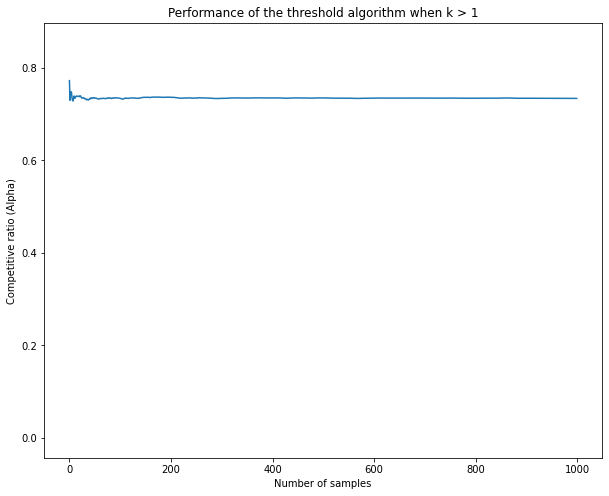

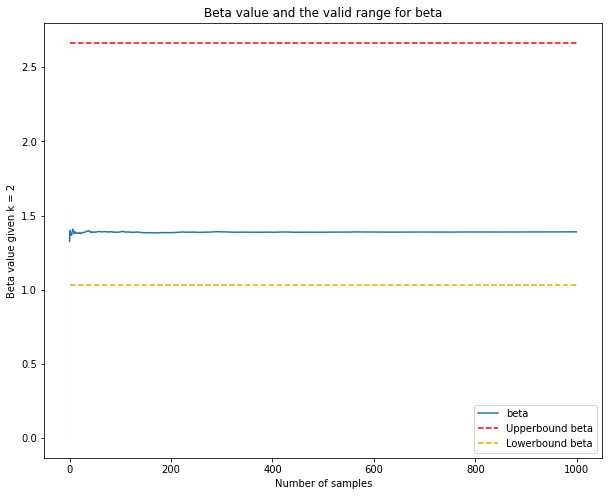

100%|██████████| 1000/1000 [01:05<00:00, 15.22it/s]


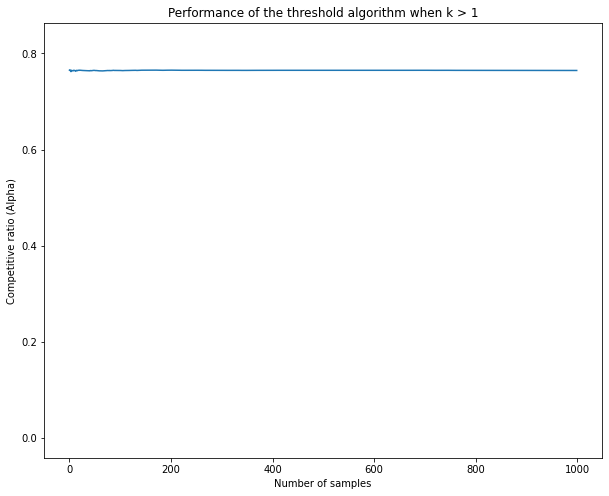

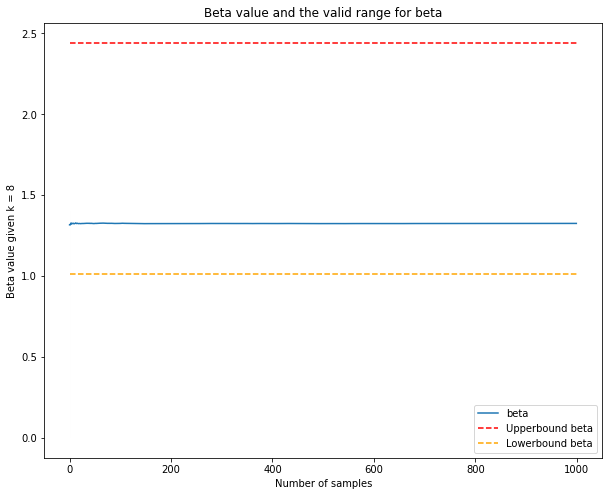

100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


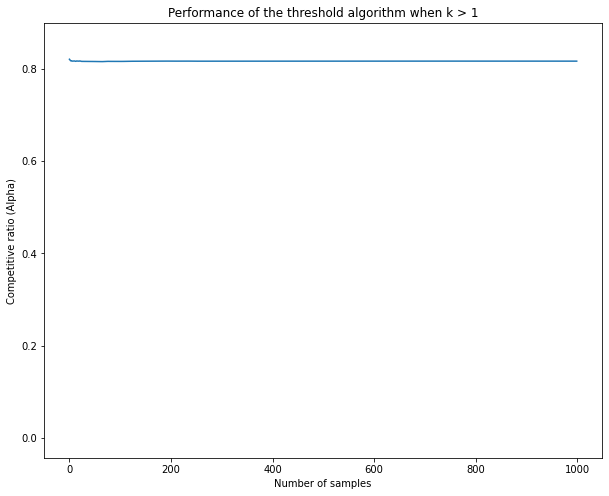

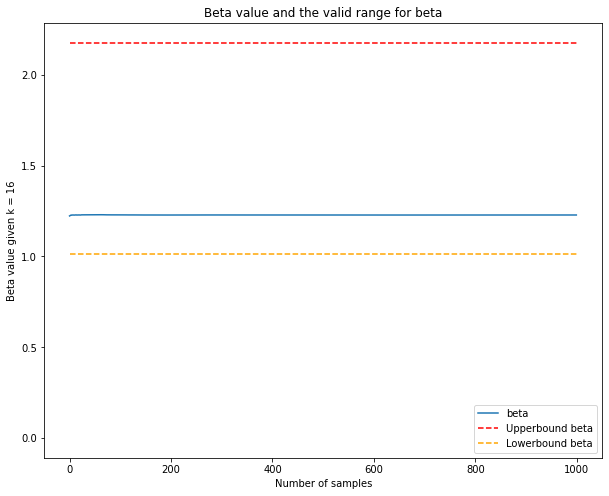

In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def plot_performance(exp_seeds, k):
    exp_seeds = np.array(exp_seeds)
    avg_alpha = np.mean(exp_seeds, axis=0)
    std_alpha = np.std(exp_seeds, axis=0) / np.sqrt(exp_seeds.shape[0])

    plt.figure(figsize=[10, 8])
    plt.plot(avg_alpha)
    plt.fill_between(avg_alpha - 2.26 * std_alpha, avg_alpha + 2.26 * std_alpha, alpha=0.2)
    plt.xlabel('Number of samples')
    plt.ylabel('Competitive ratio (Alpha)')
    plt.title("Performance of the threshold algorithm when k > 1")
    plt.savefig(f'k-{k}-search.jpg', dpi=300)
    plt.show()


def plot_beta(exp_seeds, k):
    upperbound_beta = 1 + np.sqrt(8 * np.log(k) / k)
    lowerbound_beta = 1 + np.sqrt(1 / (512 * k))
    exp_seeds = 1 / np.array(exp_seeds)
    avg_beta = np.mean(exp_seeds, axis=0)
    std_beta = np.std(exp_seeds, axis=0) / np.sqrt(exp_seeds.shape[0])

    plt.figure(figsize=[10, 8])
    plt.plot(avg_beta, label='beta')
    plt.fill_between(avg_beta - 2.26 * std_beta, avg_beta + 2.26 * std_beta, alpha=0.2)
    plt.hlines(upperbound_beta, xmin=0, xmax=exp_seeds.shape[1], linestyles='dashed', label='Upperbound beta',
               colors='red')
    plt.hlines(lowerbound_beta, xmin=0, xmax=exp_seeds.shape[1], linestyles='dashed', label='Lowerbound beta',
               colors='orange')
    plt.xlabel('Number of samples')
    plt.ylabel(f'Beta value given k = {k}')
    plt.title("Beta value and the valid range for beta")
    plt.legend(loc='lower right')
    plt.savefig(f'beta-{k}.jpg', dpi=300)
    plt.show()


def sum_prob(dists, m):
    # \sum Pr(x_i > m)
    pr = [(1 - d.cdf(m)) for d in dists]
    return np.sum(pr)


def find_threshold(dists, lr, k, initial_m=None):
    upperbound = k - np.sqrt(2 * k * np.log(k))
    if initial_m is None:
        initial_m = dists[0].rvs(1)[0]

    m_lower = m_higher = initial_m
    while True:
        # print('sum_prob_m', sum_prob_m)
        # print('upperbound', upperbound)
        # print('m', m)
        sum_prob_m_lower = sum_prob(dists, m_lower)
        sum_prob_m_higher = sum_prob(dists, m_higher)

        if sum_prob_m_lower <= upperbound:
            return m_lower
        elif sum_prob_m_higher <= upperbound:
            return m_higher

        m_lower -= lr
        m_higher += lr


def multiple_k(x_i, k, m):
    results = []
    counter_k = k
    for i in range(len(x_i)):
        if x_i[i] >= m:
            results.append(x_i[i])
            counter_k -= 1
        if len(results) == k:
            break
        elif len(x_i) - i <= counter_k:
            results.extend(x_i[i:])
            break

    # print("algo: ", results)
    return np.sum(results)


def experiment_multiple_k(k, seeds=10):
    seed_results = []
    for s in range(seeds):
        dists = get_dists(n, mean_interval=mean_interval, std_interval=std_interval)
        np.random.seed(s)
        results_algo = []
        results_prophet = []
        seed_result = []
        max_mean = dists[0].mean()
        for d in dists[1:]:
            if d.mean() > max_mean:
                max_mean = d.mean()
        m = find_threshold(dists, lr, k, max_mean)
        for _ in tqdm(range(num_samples)):
            x_i = get_x_i(dists)
            results_prophet.append(prophet(x_i, k))
            results_algo.append(multiple_k(x_i, k, m))
            seed_result.append(np.mean(results_algo) / np.mean(results_prophet))

        seed_results.append(seed_result)
        # print("Upper bound beta:", 1 + np.sqrt(8 * np.log(k) / k))
        # print("Lower bound beta:", 1 + np.sqrt(1 / (512 * k)))
        # print("beta:", np.mean(results_prophet) / np.mean(results_algo))
        # print(np.mean(results_algo) / np.mean(results_prophet))

    plot_performance(seed_results, k)
    plot_beta(seed_results, k)


if __name__ == "__main__":
    n = 64
    ks = [2, 8, 16]
    lr = 0.001
    seeds = 10
    num_samples = 1000
    mean_interval = 10
    std_interval = 1
    for k in ks:
        experiment_multiple_k(k, seeds)